<a href="https://colab.research.google.com/github/cryptocasino22/jaja/blob/main/Kopia_av_examination_3_Tidssekvenser_och_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificiell intelligens 2
## Laboration 3 Tidssekvenser och RNN


Jawad El Kaddouri

# Introduktion

Laborationens mål är att använda ett återkopplat neuronnät (eng. Recurrent Neural Network, RNN) för att göra prediktioner av en tidsserie av väderdata.

# Python Setup

In [ ]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import keras
print('Keras version:', keras.__version__)

# from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.utils  import to_categorical

# print('Keras version:',keras.__version__)

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt
#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['axes.grid'] = False

# Helper libraries
import os
import sys
import time
import datetime

import numpy as np
import pandas as pd
import sklearn
from   sklearn.model_selection import train_test_split

import IPython
import IPython.display
import seaborn as sns

TensorFlow version: 2.18.0
Keras version: 3.8.0


In [ ]:
# Test for GPU and determine what GPU we have
gpu_devices = tf.config.list_physical_devices('GPU')

if not gpu_devices:
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")
else:
  !nvidia-smi -L

# If possible to run code wiht 16 bits float instad of 32 bits float, this code activates such functionality:
if gpu_devices:
 details = tf.config.experimental.get_device_details(gpu_devices[0])
 compute_capability=details.get('compute_capability')
 print("Compute capability:",compute_capability)
 if compute_capability[0]>6:
   print("Turning on mixed_float16")
   policy = keras.mixed_precision.Policy('mixed_float16')
   keras.mixed_precision.set_global_policy(policy)

GPU 0: Tesla T4 (UUID: GPU-22541cf3-0058-fae1-9eab-650722a5fb89)
Compute capability: (7, 5)
Turning on mixed_float16


# Del 1:  Första delen av uppgiften har följande underdelar
* Förstå förbehandlingen av data som görs nedan, dels att förbereda tidssekvensen med dess olika parametrar, dels förstå hur sekvenser/fönster skapas som kan användas för att träna våra RNN-modeller.
* Reflekterar över vilken förlustfunktion som kan vara bäst för detta problem
* Skapa en baseline att jämföra med
* Träna en enkel LSTM modell för att förutsäga en parameter (temperaturen) ett steg framåt m.h.a de senaste 24 värdena som input.

## Som data används väderdata

Denna laboration använder en <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">vädertidsserie</a> uppmätt vid av Max Planck Institute for Biogeochemistry.

Denna datauppsättning innehåller 14 olika parametrar som lufttemperatur, atmosfärstryck och luftfuktighet. Dessa samlades in var tionde minut, med början 2003. För att vara lite effektiva kommer du endast att använda data som samlats in mellan 2009 och 2016. Den här delen av datamängden förbereddes av François Chollet för sin bok [Deep Learning with Python](https:// www.manning.com/books/deep-learning-with-python).


## Climate Data Time-Series
**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016

The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [ ]:

#zip_path = keras.utils.get_file(
   # origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',

    #fname='jena_climate_2009_2016.csv.zip',
    #extract=True)
#csv_path, _ = os.path.splitext(zip_path)
#df = pd.read_csv(csv_path)

from zipfile import ZipFile

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# This lab will just deal with hourly predictions, so start by sub-sampling the data from 10 minute intervals to 1h:
df = df[5::6] # starting from index 5 take every 6th record.

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [ ]:
print(df.shape)
# Let's take a glance at the data. Here are the first few rows:
df.head()

(70091, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time.

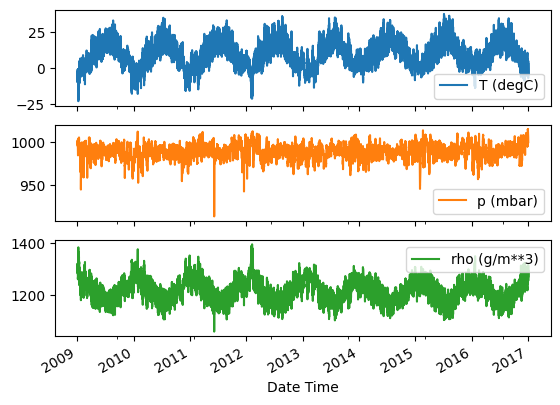

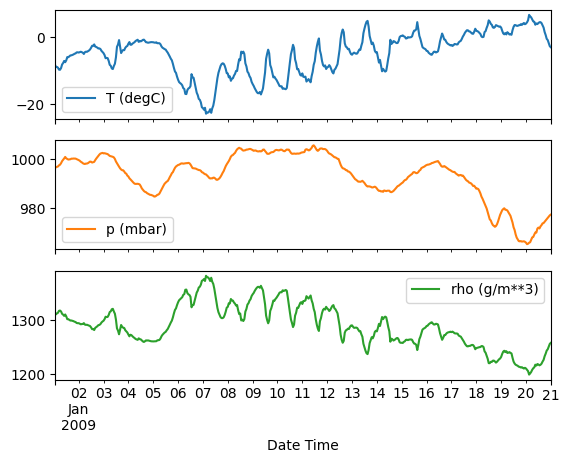

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next look at the statistics of the dataset:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity, `wv (m/s)` and `max. wv (m/s)` columns. This `-9999` is likely erroneous. There's a separate wind direction column, so the velocity should be `>=0`. Replace it with zeros:


In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

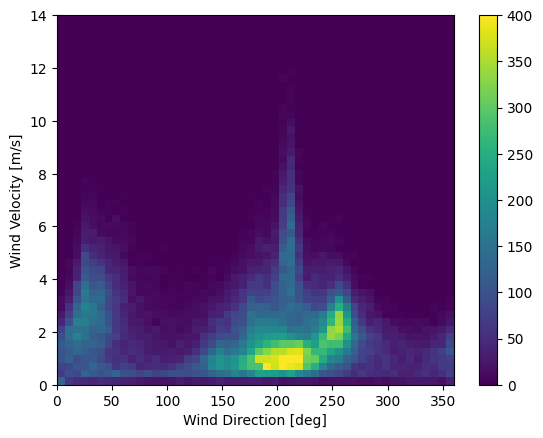

In [ ]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

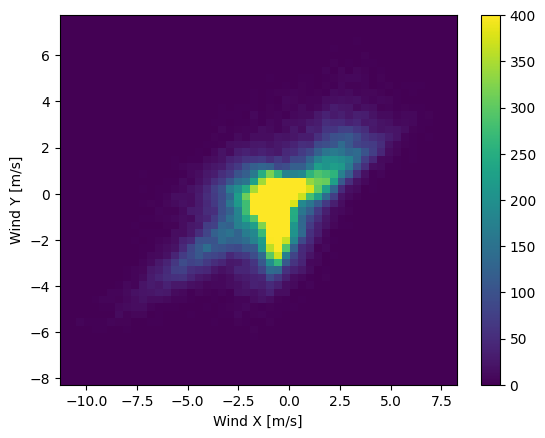

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

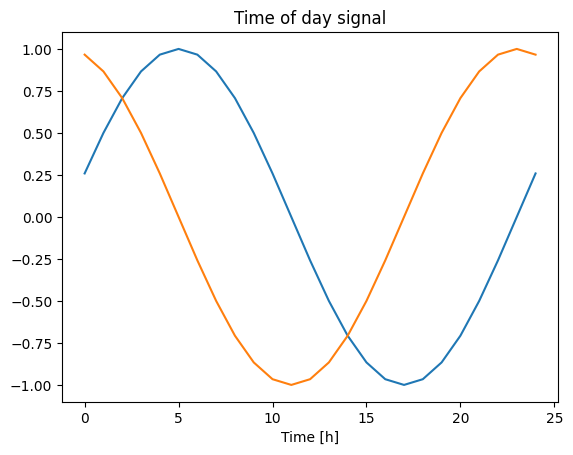

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important.

If you didn't know, you can determine which frequencies are important using an `fft` (fast fourier transform, this is not something you need to do in this course). To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`:

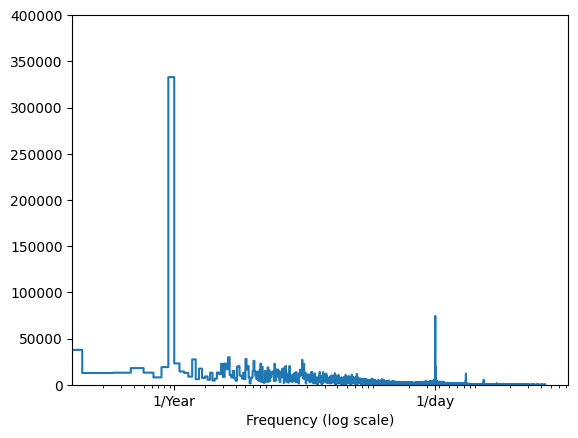

In [ ]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

## Uppgift 1: Besvara följande frågor

För godkänt omdöme (E) på laborationen så är detta den enda uppgift som behöver behandlas.

\


Denna kod gör ganska omfattande förbehandling av väderdatat innan man kan använda det för träning, se till att du förstår vad som sker (men du behöver inte förändra något) och beskriv följade:
* Det finns en eller flera variabler med extrema (fysiskt omöjliga) värden, vilka är det, och vad görs för att hantera dem?
* Varför har maskininlärningsmodeller svårt att hantera en vindriktning som anges i grader, vad föreslås som alternativ att representera vindriktning istället?
* Även tid, mätt i sekunder/timmar etc. gör det onödigt svårt för modeller att hitta mönster i vissa typer av tidsserier, vad för slags variabler föreslås i koden att man lägger till för väderdata? Om detta istället hade varit energiförbrukningsdata, vilken periodisitet borde man då utökat med?


fråga 1: Vindhastighet (wv och max_wv): i datasetet så används värdet -9999.0 för att representera saknade eller ogiltiga värden för vindhastighet (både för den aktuella vindhastigheten wv och den maximala vindhastigheten max_wv). för att besvara frågan om hur dessa extrema värden hanteras så är det så att koden ersätter dessa ogiltiga värden (-9999.0) med 0.0 på detta sätt:

wv[bad_wv] = 0.0 max_wv[bad_max_wv] = 0.0

och detta gör att alla värden som är -9999.0 i kolumnerna för vindhastighet och maximal vindhastighet ersätts med ett rimligt värde (0.0 m/s), vilket är ett mer lämpligt värde för vindhastighet om det är så att ingen faktisk vindmätning finns.


fråga 2:

När man använder grader för vindriktning, alltså där 0 och 360 grader egentligen betyder samma sak (norr), så kan modellen bli förvirrad och tro att de är långt ifrån varandra. Detta beror på att modellerna inte förstår att 0 och 360 är i princip lika nära eftersom att graderna behandlas som vanliga siffror.

För att lösa detta så omvandlar man vindriktningen till två nya siffror, sinus (sin) och cosinus (cos). Sinus och cosinus är matematiska funktioner som används för att beskriva rörelser på en cirkel. De används ofta för att hantera saker som är cykliska, som i det här fallet vindriktningar, där 0 grader och 360 grader betyder samma sak.

På så sätt, när vi har 0 grader (norr) eller 360 grader (också norr), så kommer båda att ha samma värde, vilket gör det lättare för modellen att förstå att de är samma riktning.

Så man byter alltså ut graderna mot två siffror (sinus och cosinus) för att göra det lättare för modellen att lära sig och förstå vindriktningen.



Fråga 3:

I koden för väderdata så används cykliska variabler för att hjälpa modellen att förstå tid bättre. Eftersom att tid är cyklisk, som exempelvis när dagen börjar om vid midnatt eller året börjar om i januari, så kan vi inte bara använda vanliga tal som sekunder eller timmar, utan istället så används sinus och cosinus för att omvandla tid på dygnet och årstider till siffror som visar att 0 och 24 timmar är nära varandra, eller att januari och december hör ihop eftersom att båda är en del av året.

För energiförbrukning så skulle man kunna göra något liknande. Man skulle kunna ha utökat med veckodagar eftersom energiförbrukningen kan vara högre på vissa dagar som exempelvis under helger. Man skulle även kunna utöka med månadr för att fånga mönster som förändras under året eftersom att man använder mer energi för uppvärmning under vintern eller kylning på sommaren.


##Datauppdelning och fönster

Förutom att dela upp denna tidsserie i våra tre olika datamängder behöver vi konvertera tidsserien till kortare sekvenser/fönster och lämpliga utvärden (motsvarande de "labels" vi använde i Lab 1 och 2).

Detta med fönster kan vara lite svårt att få ordning på. Om du inte redan läst colabfilen om Fönstring som hänvisades till från lektionen så se: https://colab.research.google.com/drive/1Zq_u0Wh_-P2uy1sOWwot2PrIf5OIZIo3?usp=sharing

## Back to our real data, start by finding splitting points

In [ ]:
# Find index to where we want to split our data into our datasets
DataSplitRatios=(0.7,0.2,0.1) # Maybe one should check this sums up to 1?
n = len(df)
split1ix = int(n*DataSplitRatios[0])
split2ix = int(n*(DataSplitRatios[0]+DataSplitRatios[1]))
print(split1ix,split2ix,n)

49063 63081 70091


### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.
Note that the mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

The data is normalized so that the data is in the same distribution which makes the models to be able to learn easier.

In [ ]:
train_mean = df[0:split1ix].mean()
train_std = df[0:split1ix].std()
dfnorm = (df - train_mean) / train_std

Now take a look at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

<ipython-input-18-b0c5385fac08>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


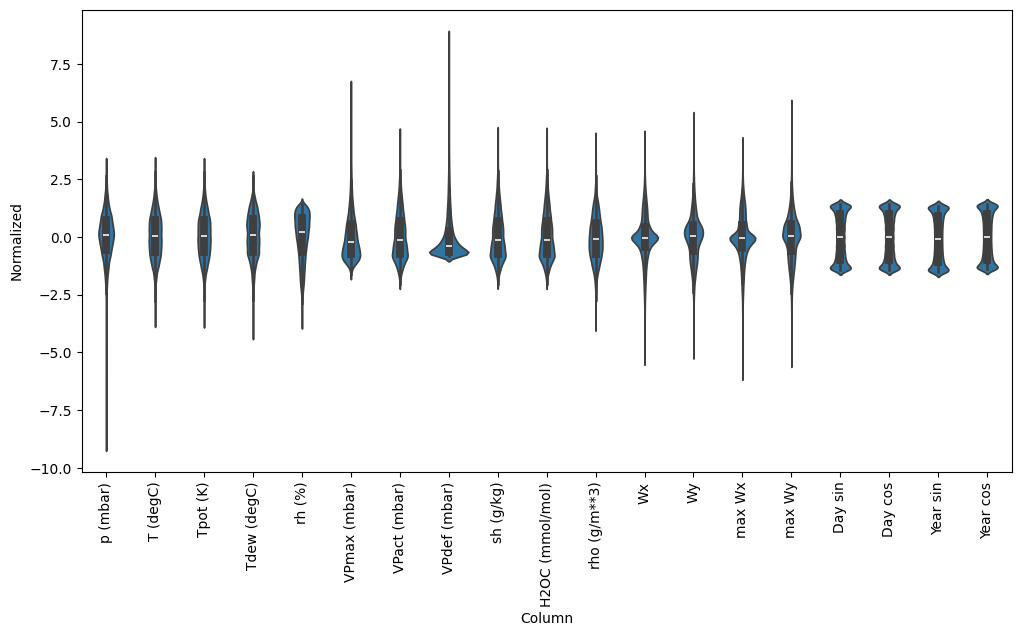

In [ ]:
df_std = dfnorm.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Uppgift 2

Denna uppgift är frivillig men rekommenderas för de som siktar på ett betyg C eller högre på kursen.

\

Vi ska prediktera en parameter (temperaturen) ett steg framåt m.h.a de senaste 24 värdena som input.

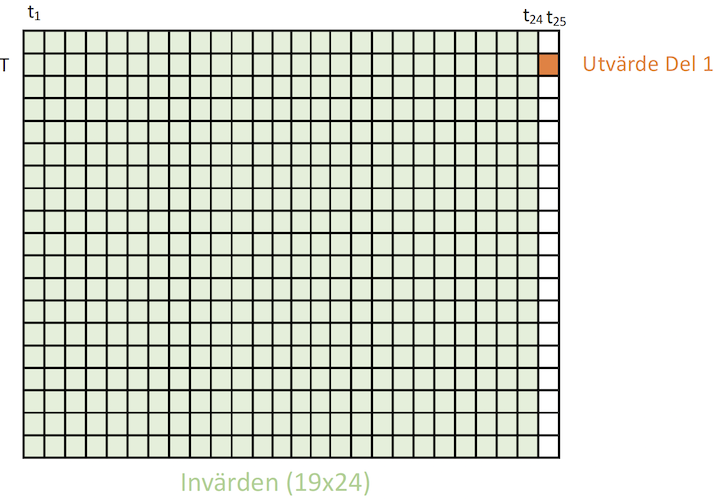

## Förbered våra tre "dataset"

In [ ]:
# Help function to get indices for columns based on column names
def get_label_columns_indices(dataframe,label_columns=None):
  if label_columns is None:
    # Take all columns if label_columns is None
    label_columns_indices = {name: i for i, name in enumerate(dataframe.columns)}
  else:
    # Else take the columns indicated
    label_columns_indices = {name: i for i, name in enumerate(label_columns)}
  return label_columns_indices

In [ ]:
# Test get_label_columns_indices
lcol= None
lci = get_label_columns_indices(dfnorm,lcol)
print(lci)
lcol= lcol= ['T (degC)']
lci = get_label_columns_indices(dfnorm,lcol)
print(lci)

{'p (mbar)': 0, 'T (degC)': 1, 'Tpot (K)': 2, 'Tdew (degC)': 3, 'rh (%)': 4, 'VPmax (mbar)': 5, 'VPact (mbar)': 6, 'VPdef (mbar)': 7, 'sh (g/kg)': 8, 'H2OC (mmol/mol)': 9, 'rho (g/m**3)': 10, 'Wx': 11, 'Wy': 12, 'max Wx': 13, 'max Wy': 14, 'Day sin': 15, 'Day cos': 16, 'Year sin': 17, 'Year cos': 18}
{'T (degC)': 0}


In [ ]:
# Define a windowing function that converts a dataframe into a TF dataset
# Had to jump to some hoops for this as keras.utils.timeseries_dataset_from_array do not support label_width>1
# https://github.com/keras-team/tf-keras/issues/7
def datasetgen(dataframe, input_width=24, label_width=1, shift=1, batch_size=128,
  label_columns=None, start_index=None, end_index=None, shuffle=False):
  """
  Generate timeseries dataset from the given dataframe containing a data sequence.

  Parameters:
  - dataframe: The source time sequence dataframe.
  - input_width: Number of time steps in each input sequence.
  - label_width: Number of time steps in each label sequence.
  - shift: How many steps to shift the end of the input to get the label.
  - batch_size: Size of batches to generate.
  - label_columns: List of column names to extract as labels. If None, all columns are used.
  - start_index: Start index from the dataframe to consider data. Default is the start of the dataframe.
  - end_index: End index from the dataframe to consider data. Default is the end of the dataframe.
  - shuffle: Whether to shuffle the generated batches. Note: shuffling won't work in the current implementation.

  Returns:
  - A TensorFlow Dataset containing input and label sequences.
  """

  # If end index or start index is not given, assign them to the end or start of the dataframe respectively.
  if end_index is None:
      end_index = len(dataframe) + input_width - 2
  if start_index is None:
      start_index = 0

  # Generate a input timeseries dataset from the dataframe using keras.utils.timeseries_dataset_from_array
  input_ds = keras.utils.timeseries_dataset_from_array(
                  dataframe, targets=None, sequence_length=input_width,
                  sequence_stride=1, sampling_rate=1, batch_size=batch_size, shuffle=shuffle,
                  start_index=start_index, end_index=(end_index-(input_width+shift-1)))

  # Fetch the indices of the label columns from the dataframe.
  label_columns_indices = get_label_columns_indices(dataframe,label_columns) # get the selected columns
  targetsdf = dataframe[list(label_columns_indices)]

  # Generate a timeseries dataset of label sequences from the dataframe.
  # Here we assume that label_width should be less than or equal to shift.
  target_ds = keras.utils.timeseries_dataset_from_array(
                  targetsdf, targets=None, sequence_length=label_width,
                  sequence_stride=1, sampling_rate=1, batch_size=batch_size, shuffle=shuffle,
                  start_index=(start_index+(input_width+shift-label_width)),
                  end_index=end_index-input_width+1)

  # Combine input and target datasets to form a single dataset.
  train_ds = tf.data.Dataset.zip(input_ds,target_ds)

  return train_ds

In [ ]:
# Now create the used datasets for part 1

input_width=24    # Input sequence length
shift=1           # How many steps to target
label_width=1     # Target sequence length
lcol=['T (degC)'] # Target parameter(s)
train_ds = datasetgen(dfnorm, input_width=input_width, label_width=label_width, shift=shift,
              label_columns=lcol, start_index=0, end_index=split1ix)
val_ds = datasetgen(dfnorm, input_width=input_width, label_width=label_width, shift=shift,
              label_columns=lcol, start_index=split1ix, end_index=split2ix)
test_ds = datasetgen(dfnorm, input_width=input_width, label_width=label_width, shift=shift,
              label_columns=lcol, start_index=split2ix, end_index=None)

In [ ]:
# Establish test targets (to show how to unroll dataset)
test_targets = None
for batch in test_ds:
  inputs, targets = batch
  if test_targets == None:
    test_targets = targets
  else:
   test_targets = tf.concat([test_targets,targets], axis=0)

# Print number of targets (i.e. windows in target dataset)
print(f'No of targets = {test_targets.shape[0]}')
# And number of features
num_target_features = targets.shape[1]
print(f'No of features in target = {num_target_features}')


No of targets = 6985
No of features in target = 1


In [ ]:
# Get a batch and look at the shapes for one of the datasets
eval_ds = test_ds
for batch in eval_ds:
  inputs, targets = batch
  batchlen = len(inputs)
  # We here have a batch of seqlen sequences
  print("A Batch Input shape = {0}, Output shape = {1}".format(inputs.shape,targets.shape))
  break

print(f'No batches = {eval_ds.__len__()}')

A Batch Input shape = (128, 24, 19), Output shape = (128, 1, 1)
No batches = 55


### Now we can use the datasets needed for training

# Del 2

Denna del är frivillig men rekommenderas för de som siktar på ett betyg C eller högre på kursen.

## Uppgift 3:
Reflektera över vilken förlustfunktion som kan vara bäst för detta problem (mean squared error, MSE, eller mean absolute error,  MAE, eller något annat?) och varför denna exempelkod väljer att använda just “loss=tf.losses.MeanSquaredError()” och “metrics=tf.metrics.MeanAbsoluteError()”.  Tillägna en sektion i din rapport till att argumentera för skillnaden mellan en förlustfunktion (loss) och ett prestationsmått (metric), samt motivera ditt val av förlustfunktion.



I koden så används Mean Squared Error (MSE) som förlustfunktion (loss) och Mean Absolute Error (MAE) som prestationsmått (metric).

MSE är ett sätt att mäta hur bra en modell gör sina förutsägelser. Den tar alla fel, alltså skillnaden mellan förutsägelsen och det riktiga värdet, kvadrerar dem och räknar sedam ut ett genomsnitt. Stora fel blir extra stora när de kvadreras, så de påverkar resultatet mer än små fel. Detta betyder att stora fel straffas hårdare än små fel eftersom att felet kvadreras. MSE är bra för regressionsproblem där stora fel är oacceptabla och ska undvikas. En fördel med MSE är att det ger en tydlig signal till optimeringsalgoritmen (adam) om hur felet ska minimeras. En nackdel är dock att det är känsligt för outliers (värden som sticker ut från de andra), eftersom stora fel kvadreras och får en oproportionerligt stor påverkan på förlusten. Dessutom är det svårare att tolka eftersom enheten för förlusten är kvadratisk, exempelvis kvadratmeter istället för meter.

MAE är ett prestationsmått som beräknar det genomsnittliga absoluta felet mellan de förutsagda värdena och de faktiska värdena. Här behandlas alla fel lika, oavsett storlek. En fördel med MAE är att det är mindre känsligt för outliers jämfört med MSE. Det är också lättare att tolka eftersom enheten är densamma som måttet, exempelvis meter. En nackdel är dock att det inte ger lika stark signal till optimeringsalgoritmen som MSE, vilket kan göra träningen långsammare eller mindre effektiv.

Varför används då MSE som förlustfunktion och MAE som prestationsmått?
  
MSE används som förlustfunktion för att träna modellen eftersom det ger en stark signal till optimeringsalgoritmen och är effektivt för att minimera stora fel. Det är särskilt användbart i regressionsproblem där stora avvikelser är oönskade. MAE används som prestationsmått för att utvärdera modellen eftersom det är lättare att tolka och ger en bättre uppfattning om hur stora de genomsnittliga felen är i samma enheter som måttet. Det är också mindre känsligt för outliers, vilket gör det till ett mer robust mått för utvärdering.

---

Skillnaden mellan en förlustfunktion och ett prestationsmått är att loss är det som modellen försöker minimera under träningen, medan metric bara används för att mäta prestandan. Förlustfunktionen styr alltså hur modellen lär sig, medan metric hjälper till att utvärdera hur bra den fungerar. Man kan tänka på det som att förlustfunktionen är kartan som modellen följer, medan metric är hastighetsmätaren som man tittar på för att se hur snabbt man kommer fram.

Genom att använda MSE som loss får vi en modell som tränas på att minimera stora misstag, vilket gör den mer exakt. Samtidigt så använder jag MAE som metric eftersom det ger ett enkelt och tydligt sätt att förstå hur mycket fel modellen gör i praktiken. Detta val gör att man kan optimera träningen på ett smart sätt och samtidigt få tydliga resultat som är lätta att tolka

---

Motivering av mitt val av förlustfunktion


I den här uppgiften så arbetar jag med tidsseriedata, där man vill att modellen ska bli så noggrann som möjligt när den förutsäger framtida värden. Därför har jag valt att använda mig av Mean Squared Error (MSE) som förlustfunktion och Mean Absolute Error (MAE) som prestationsmått.  

MSE är ett bra val enligt mig eftersom att den kvadrerar felen, vilket i sig gör att större fel straffas mer. Detta betyder att modellen kommer att fokusera mer på att minska stora misstag, vilket kan göra den mer exakt i sin slutsats. Om jag istället hade använt mig av MAE som förlustfunktion, så skulle modellen inte bry sig lika mycket om stora fel, vilket kan vara ett problem om man vill att den ska bli mer noggrann över tid.  

Anledningen till att koden använder MSE som förlustfunktion och MAE som prestationsmått är för att dessa två kompletterar varandra bra. MSE används under träningen för att modellen ska lära sig att minimera de största felen, medan MAE används för att mäta hur modellen presterar på ett sätt som är lätt att förstå. MAE redovisar ett genomsnittligt fel i samma enhet som det man vill förutspå, som exempelvis celsius grader i detta fall när den ska förutspå temperatur. Om jag hade använt MSE som prestationsmått, så skulle man få ett mer svårtolkat värde eftersom kvadreringen av felen gör det större än verkliga avvikelser. MSE ger även en stark signal till optimeringsalgoritmen (adam), vilket gör träningen effektiv. Om datan har få eller inga outliers alls, så är MSE ett stabilt och lämpligt val.



You will train a lot of models, so it might be useful to package the training procedure into a function:

In [ ]:
MAX_EPOCHS = 30

def compile_and_fit(model, patience=5):
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights = True)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  start = time.time()
  history = model.fit(train_ds, epochs=MAX_EPOCHS,
                      validation_data=val_ds,
                      callbacks=[early_stopping])
  end = time.time()
  print(f'Time to run: {end - start:.1f}s')

  return history,model

##Skapa en Modell

In [ ]:
# Define a first simple LSTM model with 32 units
lstm_model_baseline = keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    keras.layers.Dense(units=num_target_features)
])

Compile and train this model, and then plot the training curves. That is, the following graph shows the baseline LSTM model with a 24 sized(timepoints) array as input and a 1 sized output prediction(next timepoint).

In [ ]:
# Compile and train this model
history_lstm_baseline,lstm_model_baseline1=compile_and_fit(lstm_model_baseline)

Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.3343 - mean_absolute_error: 0.3598 - val_loss: 0.0268 - val_mean_absolute_error: 0.1299
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0251 - mean_absolute_error: 0.1173 - val_loss: 0.0200 - val_mean_absolute_error: 0.1118
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0167 - mean_absolute_error: 0.0958 - val_loss: 0.0145 - val_mean_absolute_error: 0.0929
Epoch 4/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0126 - mean_absolute_error: 0.0836 - val_loss: 0.0121 - val_mean_absolute_error: 0.0852
Epoch 5/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0101 - mean_absolute_error: 0.0750 - val_loss: 0.0106 - val_mean_absolute_error: 0.0805
Epoch 6/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0091 - mean_absolute_error: 0.0702 - val_loss: 0.0149 - val_mean_absolute_error: 0.0970
Epoch 7/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0104 - mean_absolute_error: 0

Test accuracy: 0.060
Test loss: 0.0066


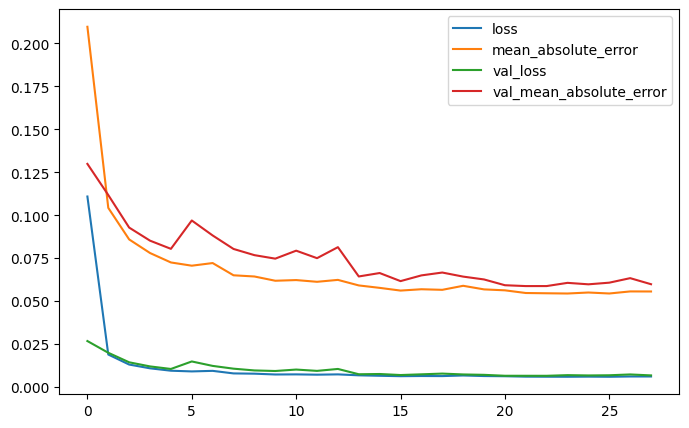

In [ ]:
# Evaluate the model.
test_loss, test_acc = lstm_model_baseline1.evaluate(test_ds, verbose=0)
print('Test accuracy: %.3f' % test_acc)
print('Test loss: %.4f' % test_loss)

# Plot the training curves
pd.DataFrame(history_lstm_baseline.history).plot(figsize=(8,5))
plt.show()

Note that this is the normalised loss!

## Example plot of predictions

In [ ]:
# define a plot function to show how well it is predicting
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


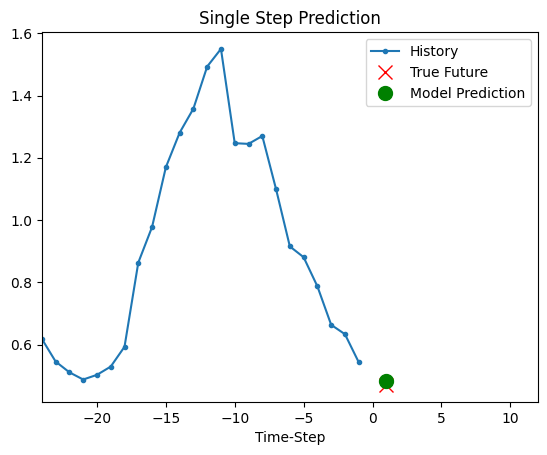

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


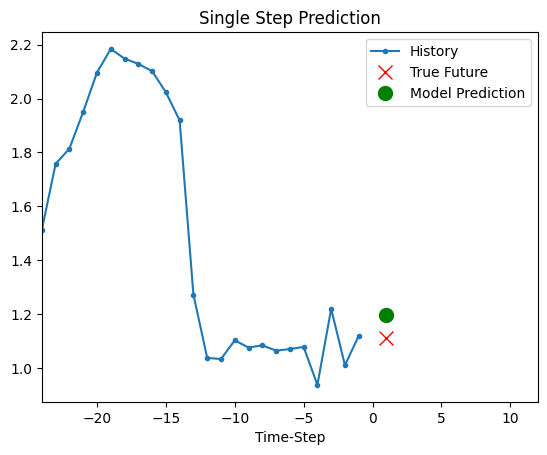

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


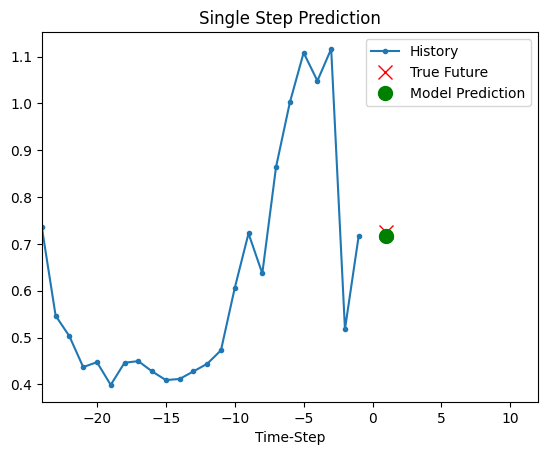

In [ ]:
for x, y in val_ds.take(3):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), lstm_model_baseline1.predict(x)[0]],
        1,
        "Single Step Prediction",
    )

## Plot Some Results - Unnormalised
Just for fun, some code to unnormalise the predictions, and plot the difference between the true values and the predictions. But for the lab you can work in normalised space as long as you are consistent!

In [ ]:
predict = lstm_model_baseline1.predict(test_ds)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [ ]:
def unnorm(data,label_columns_index):
  assert len(label_columns_index) == data.shape[-1]
  tm = train_mean.get(list(label_columns_index)).values
  ts = train_std.get(list(label_columns_index)).values
  return  data * ts + tm


In [ ]:
ttt = unnorm(test_targets,label_columns_index=lci).numpy().squeeze()
ttp = unnorm(predict,label_columns_index=lci).squeeze()

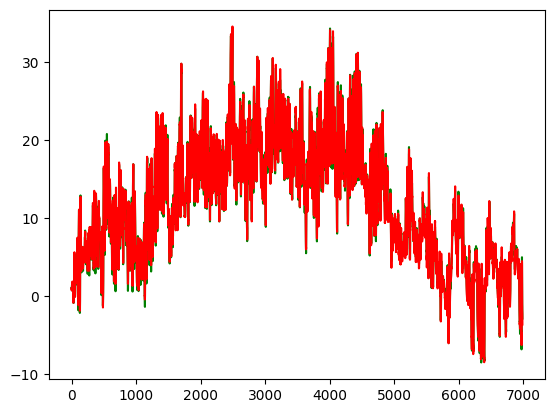

In [ ]:
plt.figure()
plt.plot(ttt,color='g')
plt.plot(ttp, color='r')

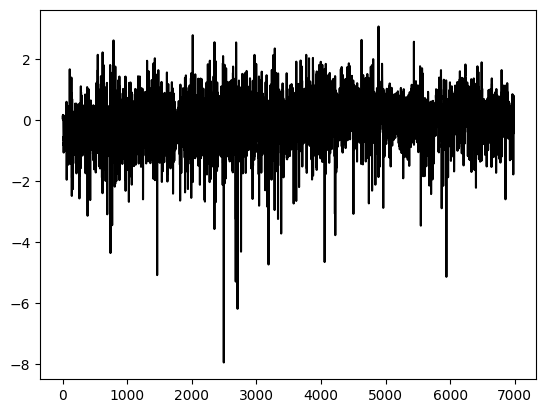

In [ ]:
plt.figure()
plt.plot(ttt-ttp,color='k')


##Uppgift 4
För att ha något att jämföra med så skulle vi behöva räkna ut en baslinjemodell. En vanlig och enkel baseline är att bara "prediktera" nästa värde att vara samma som nuvarande värde (detta är ganska rimligt för väderprediktion).

* Räkna ut en "baseline" med samma förlustfunktion som du bestämt dig för att använda i denna laboration.
* Var den enkla LSTM-modellen ovan bättre eller sämre än din baseline?

Tips: Du ska räkna ut MSE/MAE utifrån ditt testdata. Det finns två huvudmetoder att skapa de prediktiva värden och sanna värden vi behöver för detta.
1.   Plocka ut hela temperaturserien från dfnorm: "dfnorm['T (degC)'].to_numpy()" och sedan bestämma start och slutpunkter i denna tidsserie för input (notera att det är 24 invärden och därför är startpunkten förskjuten motsvarande och även slutpunkten är förskjuten då sista värdet måste "ha plats" för 24 invärden)
2.   Det andra sättet är att loopa över alla batcher i testdataströmmen
```
for batch in eval_ds:
      inputs, targets = batch
```
och sedan extrahera rätt del av "inputs" (full batch, last input-sequece data, temp column) och hela "targets" för att sedan konkatenera alla batcher till en lång vektor.

In [ ]:
# Baseline calculation


# skapa baseline prediktioner
baseline_preds = []
true_values = []

for batch in test_ds:
    inputs, targets = batch
    last_values = inputs[:, -1, 1]  # tar den sista temperaturvärdet från input
    baseline_preds.extend(last_values.numpy())  # sparar baseline prediktionerna
    true_values.extend(targets.numpy().squeeze())  # sparar de verkliga målvärdena

# konvertera till numpy array
baseline_preds = np.array(baseline_preds)
true_values = np.array(true_values)

# beräknar MSE och MAE för baseline
baseline_mse = np.mean((baseline_preds - true_values) ** 2)
baseline_mae = np.mean(np.abs(baseline_preds - true_values))

print(f"Baseline MSE: {baseline_mse:.4f}")
print(f"Baseline MAE: {baseline_mae:.4f}")

# beräknar MSE och MAE för LSTM-modellen (prediktionerna är uträknade sedan tidigare)
lstm_mse = np.mean((ttp - ttt) ** 2)
lstm_mae = np.mean(np.abs(ttp - ttt))

print(f"LSTM MSE: {lstm_mse:.4f}")
print(f"LSTM MAE: {lstm_mae:.4f}")

# jämför baseline med LSTM-modellen
if lstm_mse < baseline_mse:
    print("LSTM-modellen är bättre än baseline eftersom den har lägre MSE!")
else:
    print("Baseline är lika bra eller bättre än LSTM-modellen (LSTM behöver kanske justeras).")

if lstm_mae < baseline_mae:
    print("LSTM-modellen är bättre än baseline eftersom den har lägre MAE!")
else:
    print("Baseline är lika bra eller bättre än LSTM-modellen baserat på MAE.")


Baseline MSE: 0.0142
Baseline MAE: 0.0854
LSTM MSE: 0.4955
LSTM MAE: 0.5195
Baseline är lika bra eller bättre än LSTM-modellen (LSTM behöver kanske justeras).
Baseline är lika bra eller bättre än LSTM-modellen baserat på MAE.


Koden går igenom testdatan för att hämta två saker. Först baseline-förutsägelser och sedam verkliga målvärden. Baseline-förutsägelserna görs genom att ta det senaste värdet i input sekvensen och använda det som nästa värde. De verkliga målvärdena samlas in för att man därefter ska kunna jämföra dem med både baseline och LSTM-modellens förutsägelser.  

Därefter så beräknas Mean Squared Error och Mean Absolute Error för baseline. MSE mäter det genomsnittliga kvadratiska felet, medan MAE mäter det genomsnittliga absoluta felet. Dessa värden används för att jämföra baseline med LSTM-modellen.  

Om LSTM-modellen har lägre MSE och MAE än baseline, så betyder det att den har lärt sig att göra bättre förutsägelser än en enkel gissning där man sedan antar att nästa värde är detsamma som det senaste. Men om baseline har lika bra eller bättre MSE/MAE-värde än LSTM, så betyder det att modellen behöver justeras, eftersom att den inte presterar bättre än en grundläggande gissning.  

Slutsatsen är att om LSTM har lägre fel än baseline, så visar det att modellen faktiskt lär sig något och förbättrar sina förutsägelser. Om den inte gör det, kan det vara ett tecken på att den behöver tränas om eller justeras för att fungera bättre.

# Del 3

Denna del är frivillig men rekommenderas för de som siktar på ett högre betyg än C på kursen.

## Uppgift 5 - En bättre LSTM-modell

Nästa steg är att hitta en förbättrad LSTM-modell för fallet när man vill prediktera en parameter (temperaturen) ett steg framåt m.h.a de senaste 24 värdena som input. Notera att det kan vara svårt att slå den första enkla LSTM-modellen för just detta problem och data, men försök.

Du kan pröva med fler noder i ditt lager eller lägga till fler lager. Notera att man INTE bör använda activation='relu' för LSTM-modeller då dessa modellerna inte kan köras på GPU:n i så fall. Om du lägger till flera lager så vill du nog ange "return_sequences=True" till alla lager utom det sista.

Pröva att använda någon av de de regulariseringsmetoder som finns tillgängliga för RNN och se ifall du på så sätt kan förbättra din modell (detta ska vara regularisering av LSTM lagren, inte t.ex. dropout mellan lagren). Argumentera för dina val av regularisering och diskutera dina resultat. Notera även ifall någon av regulariseringarna du testat tvingar modellen till CPU:n istället för GPU:n. Beskrivning av vilka parametrar som styr regulariseringen i LSTM finns här: https://keras.io/api/layers/recurrent_layers/lstm/
(kernel_regularizer, recurrent_regularizer, bias_regularizer, activity_regularizer, dropout, recurrent_dropout).
Notera att dessa regulariseringsmetoder sällan har gett någon väsentlig förbättring i denna laboration, vad kan detta bero på?

Att vanlig dropout kanske inte är så bra finns först beskrivet i följande artikel:
* Zaremba, W., Sutskever, I., & Vinyals, O. (2014). Recurrent neural network regularization. arXiv preprint arXiv:1409.2329

Men det kan ändå vara värt att pröva just innan de sista kompakta lagren i modellen?

**Analysera dina resultat och jämför de olika modellerna.**


In [ ]:
# Better LSTM model(s): definition, compile and run, evaluate, and compare!

# Uppgift 6 Prediktera flera steg framåt

Du ska göra två olika modeller som båda ska prediktera vad temperaturen är 24 timmar framåt, baserat på de senaste 24 timmarnas mätvärden. D.v.s om din input-sekvens t.ex. löper från timme 1 till och med timme 24, så ska du prediktera vad temperaturen är vid timme 48.

## Uppgift 6.1 24-timmar framåt med "direkt prediktion"
 Direkt-prediktion av det värdet du söker (single-step with a new target time-step). D.v.s använd 24 timmars input-värden för att endast prediktera ett utvärde. 24 timmar framåt (timme 48).

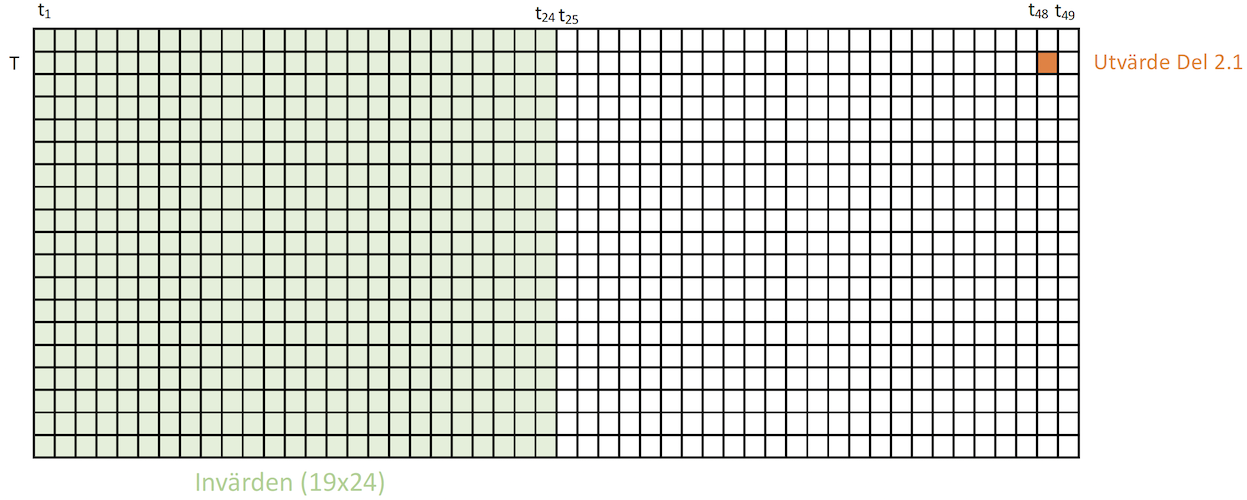

In [ ]:
# A good LSTM model from above but predict at 48 instead of 24

Skapa en baseline även för detta fall. Notera att då vi predikterar precis 24h framåt så kommer denna baseline att vara förvånandsvärt bra, fundera på vad som hade hänt ifall vi istället skulle prediktera 12h framåt istället för 24h.


In [ ]:
# Baseline calculation for predicting 24h into the future

## Uppgift 6.2 24-timmar framåt med "mellanliggande prediktioner"
Gör en prediktion av alla mellanliggande värden också. D.v.s använd återigen 24 timmars input-värden, men prediktera alla värden från timme 25 till och med timme 48. Din output blir nu en 24 värden lång vektor vid varje prediktion.

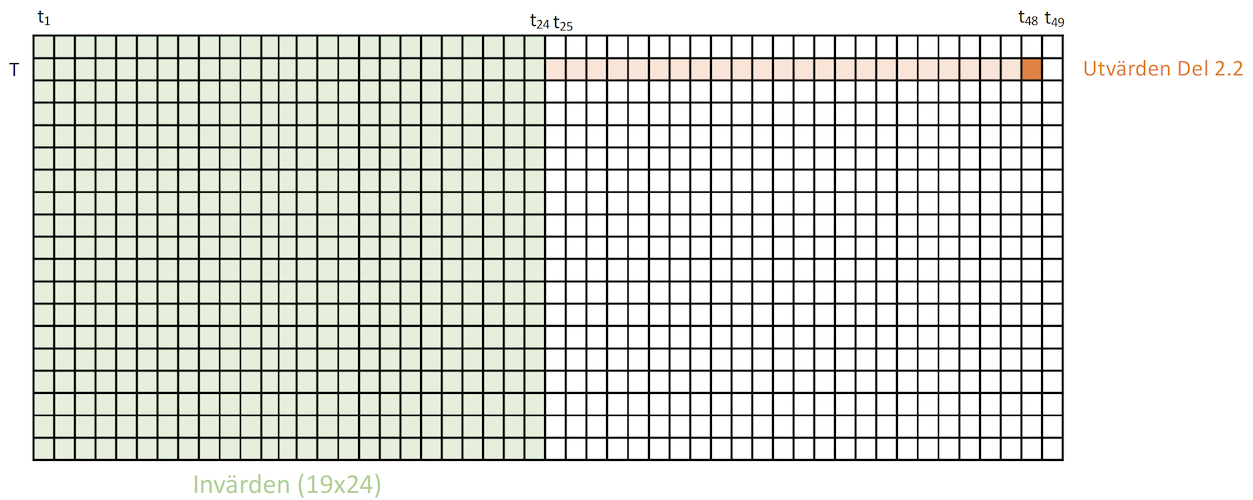

Notera att vi för dessa två modeller endast är intresserad av kvalitén av prediktionen vid timme 48, så du behöver hitta ett sätt att mäta prestationen för just denna timme för att kunna jämföra modellerna mot modell 5.1 och sinsemellan.

Mät felet “manuellt” genom att plocka ut målvärdena och prediktionen (sista värdet) för testdatat och sedan beräkna felet enligt den metod du valt. Alternativt kan något i stil med följande användas.

```
def last_time_step_mse(Y_true, Y_pred):
   return keras.losses.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
```




In [ ]:
# A good LSTM model from above but predict all values from 24-48 instead of just 24

## Uppgift 7 Analys


Jämför prestandan för dina olika modeller sinsemellan och mot baseline, vilka slutsatser drar du? Och, hur väl presterar dessa modeller i jämförelse med fallet i del 3 där vi bara behövde prediktera ett steg framåt?

# Överkurs

Denna del är frivillig.

##Uppgift - GRU
Pröva att ersätta LSTM med GRU (en annan RNN modell) med samma antal noder och lager som för din bästa LSTM modell i del 1. Finner du någon skillnad i prestanda, konvergens, tidsåtgång vid träning, eller annat?

In [ ]:
# An GRU model: definition, compile and run, evaluate, and compare!

## Uppgift - Återkopplad modell
Du ska som i del 5 prediktera vad temperaturen är vid timme 48. Men denna gång ska du göra en enstegsprediktion 24 gånger och hela tiden låta den senaste prediktionen vara del av invärdena till nästa stegs prediktion (Autoregressive predictions). Notera att för att detta ska fungera så måste man prediktera alla 19 värden som output och inte bara temperaturen.

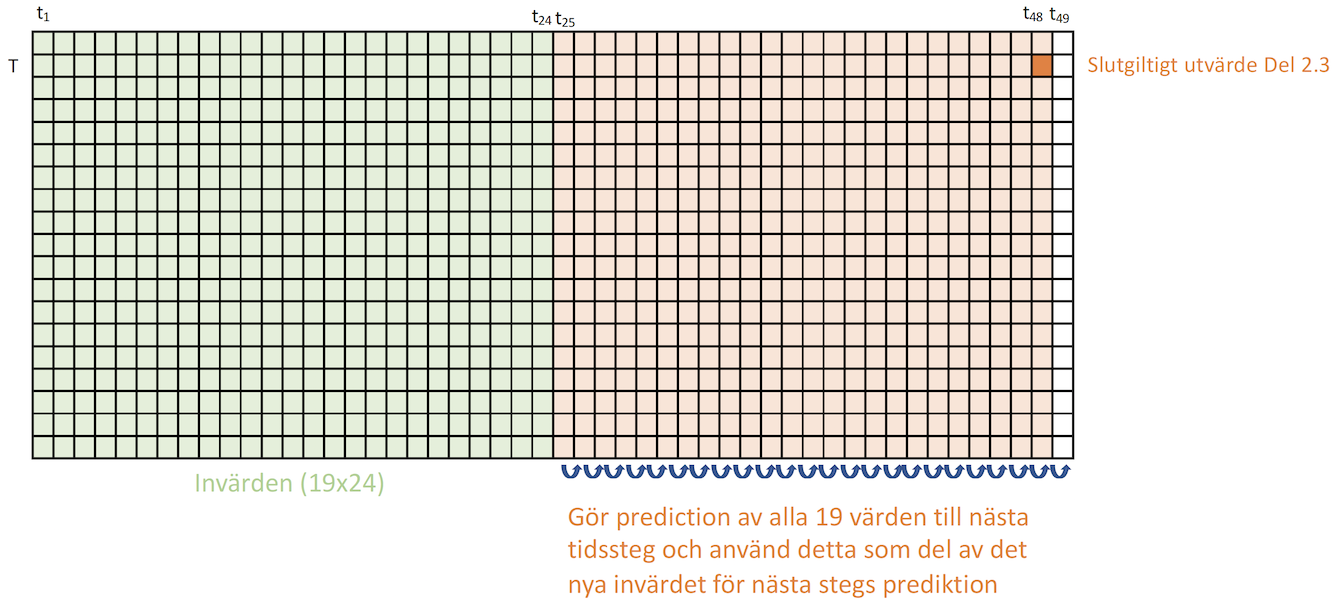

## Uppgift -- Analys
Jämför prestandan för dina olika modeller sinsemellan, vilka slutsatser drar du? Och, hur väl presterar denna modell i jämförelse med de du analyserade i del 2?

#Referenser
Delar av denna kod är baserad på
* Tidigare TF-exempel https://www.tensorflow.org/tutorials/structured_data/time_series
* Geron, "Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow 3e -- Concepts, Tools, and Techniques to Build Intelligent Systems" Kapitel 15, från "Preparing the Data for Machine Learning Models", s. 552, och dess kodexempel: https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb
* Timeseries forecasting for weather prediction https://keras.io/examples/timeseries/timeseries_weather_forecasting/ (but note that this code is not doing a correct preprocessing/feature engineering of various features like: missing values in wind speed, wind direction, and time.)